## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [27]:
import numpy as np
import pandas as pd
from itertools import chain
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
pairs = pd.read_csv("data/ncbi/raxml/pairs.csv")
sgenes = pd.read_csv("data/ncbi/ncbi_sgene_good_unique_aligned.csv")

In [10]:
batch_size = 64      # Batch size for training.
epochs = 100         # Number of epochs to train for.
latent_dim = 256     # Latent dimensionality of the encoding space.
num_pairs = 100  # Number of samples to train on.

## Data prep

In [25]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

In [28]:
for index, pair in pairs.iterrows():
    if index == num_pairs:
        break
    
    parent_sgene = sgenes[sgenes["accession"]==pair["parent"]]["sgene_nucleotide"].values[0]
    child_sgene = sgenes[sgenes["accession"]==pair["child"]]["sgene_nucleotide"].values[0]
    
    input_texts.append(parent_sgene)
    target_texts.append(child_sgene)

input_characters = set(chain.from_iterable(input_texts))
target_characters = set(chain.from_iterable(target_texts))

In [29]:
input_characters

{'-', 'A', 'C', 'G', 'T'}

In [30]:
target_characters

{'-', 'A', 'C', 'G', 'T'}

In [31]:
print("input_texts ", len(input_texts))
print("target_texts", len(target_texts))
print("input_characters", len(input_characters))
print("target_characters", len(target_characters))

input_texts  200
target_texts 200
input_characters 5
target_characters 5


In [32]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 200
Number of unique input tokens: 5
Number of unique output tokens: 5
Max sequence length for inputs: 3873
Max sequence length for outputs: 3873


In [33]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print("input_token_index", len(input_token_index))
print("target_token_index", len(target_token_index))

input_token_index 5
target_token_index 5


In [34]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
print("encoder_input_data.shape", encoder_input_data.shape)
print("decoder_input_data.shape", decoder_input_data.shape)
print("decoder_target_data.shape", decoder_target_data.shape)

encoder_input_data.shape (200, 3873, 5)
decoder_input_data.shape (200, 3873, 5)
decoder_target_data.shape (200, 3873, 5)


In [39]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
#     encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0 # for spaces
    
    for t, char in enumerate(target_text):
        
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
            
#     decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0 # for spaces
#     decoder_target_data[i, t:, target_token_index[" "]] = 1.0 # for spaces
    

## Construct model

In [40]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape = (None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state = True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape = (None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation = "softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 256), (None, 268288      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  268288      input_4[0][0]                    
                                                                 lstm_2[0][1]               

In [42]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 619015318314263561
]


## Train model

In [43]:
model.compile(
    optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]
)

es = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 10, verbose = 1, restore_best_weights = True)

log = model.fit(
    [ encoder_input_data, decoder_input_data ],
    decoder_target_data,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [ es ],
    validation_split = 0.2,
)

Epoch 1/100
3/3 [==============================] - 37s 11s/step - loss: 1.5877 - accuracy: 0.2836 - val_loss: 1.6222 - val_accuracy: 0.1941
Epoch 2/100
3/3 [==============================] - 38s 13s/step - loss: 1.5318 - accuracy: 0.2491 - val_loss: 1.4060 - val_accuracy: 0.3333
Epoch 3/100
3/3 [==============================] - 36s 12s/step - loss: 1.4013 - accuracy: 0.3217 - val_loss: 1.3708 - val_accuracy: 0.3323
Epoch 4/100
3/3 [==============================] - 37s 12s/step - loss: 1.3713 - accuracy: 0.3330 - val_loss: 1.3677 - val_accuracy: 0.3339
Epoch 5/100
3/3 [==============================] - 37s 13s/step - loss: 1.3694 - accuracy: 0.3366 - val_loss: 1.3695 - val_accuracy: 0.3339
Epoch 6/100
3/3 [==============================] - 43s 15s/step - loss: 1.3720 - accuracy: 0.3226 - val_loss: 1.3705 - val_accuracy: 0.3004
Epoch 7/100
3/3 [==============================] - 50s 16s/step - loss: 1.3708 - accuracy: 0.3111 - val_loss: 1.3705 - val_accuracy: 0.3339
Epoch 8/100
3/3 [===

3/3 [==============================] - 40s 13s/step - loss: 1.2948 - accuracy: 0.3722 - val_loss: 1.2912 - val_accuracy: 0.3748
Epoch 60/100
3/3 [==============================] - 40s 13s/step - loss: 1.2936 - accuracy: 0.3743 - val_loss: 1.3029 - val_accuracy: 0.3695
Epoch 61/100
3/3 [==============================] - 40s 13s/step - loss: 1.3055 - accuracy: 0.3683 - val_loss: 1.2952 - val_accuracy: 0.3689
Epoch 62/100
3/3 [==============================] - 40s 13s/step - loss: 1.2937 - accuracy: 0.3686 - val_loss: 1.2869 - val_accuracy: 0.3751
Epoch 63/100
3/3 [==============================] - 40s 13s/step - loss: 1.2875 - accuracy: 0.3776 - val_loss: 1.2984 - val_accuracy: 0.3684
Epoch 64/100
3/3 [==============================] - 43s 15s/step - loss: 1.2950 - accuracy: 0.3720 - val_loss: 1.2815 - val_accuracy: 0.3798
Epoch 65/100
3/3 [==============================] - 41s 14s/step - loss: 1.2839 - accuracy: 0.3800 - val_loss: 1.2848 - val_accuracy: 0.3831
Epoch 66/100
3/3 [========

In [44]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

# Save model
model.save("data/ncbi/raxml")

INFO:tensorflow:Assets written to: data/ncbi/raxml/assets


INFO:tensorflow:Assets written to: data/ncbi/raxml/assets


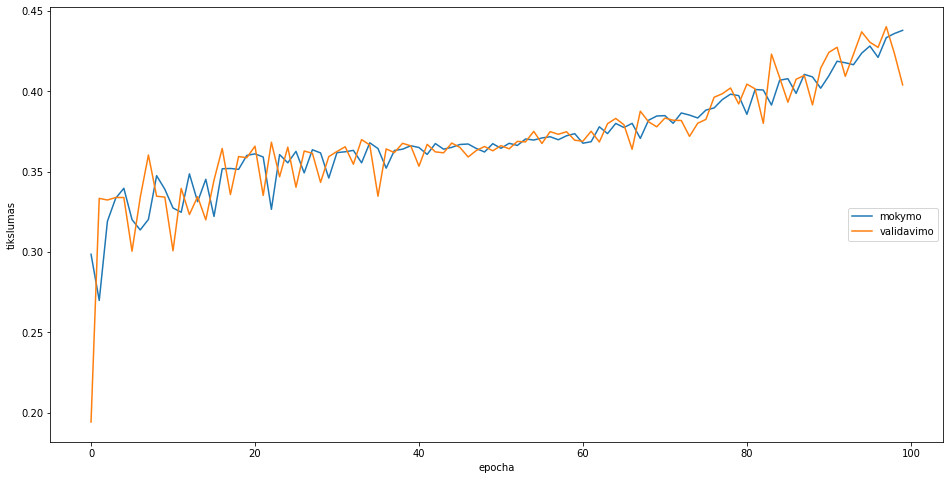

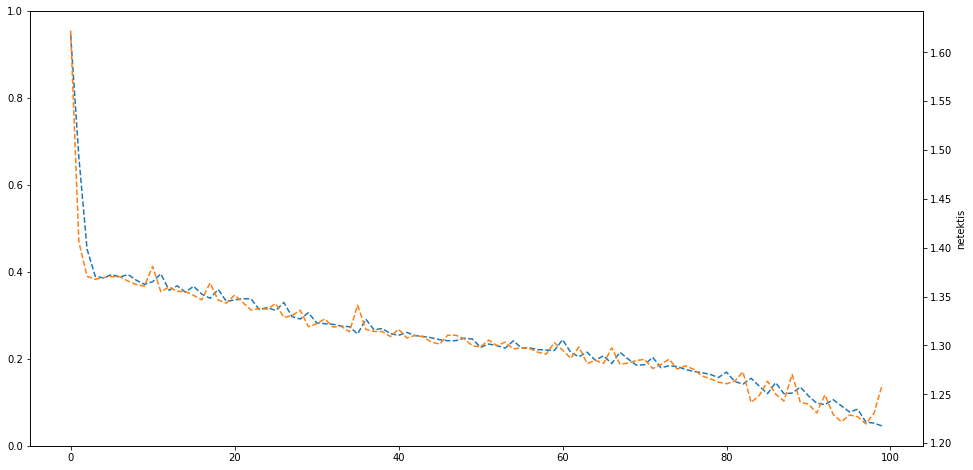

In [46]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend(loc='right') #['mokymo', 'testavimo'])
plt.show()
ax2 = plt.twinx()
ax2.plot(log.history['loss'], '--', label = 'mokymo')
ax2.plot(log.history['val_loss'], '--', label = 'validavimo')
ax2.set_ylabel('netektis')
#plt.title('model accuracy')
plt.show()

## Inference

In [47]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("data/ncbi/raxml")

In [49]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [50]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [52]:
# for seq_index in range(20):
#     # Take one sequence (part of the training set)
#     # for trying out decoding.
#     input_seq = encoder_input_data[seq_index : seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)
#     print("-")
#     print("Input sentence:", input_texts[seq_index])
#     print("Decoded sentence:", decoded_sentence)